In [1]:
import fnmatch
import os
import pprint
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_clustering_helpers import parse_dend, plot_htree, do_merges, \
                                        get_cvfold_extended, predict_leaf_gmm, get_cca_projections,get_cvfold

**Dataset description**

The patch-seq dataset analyzed in the manuscript consists of 
 - `2945 x 1252` cells x genes matrix: Transcriptomic data
 - `4637 x 54` cells x sPCA features: Electrophysiological data
 
Among these, `1518` cells were mapped to leaf nodes in the hierarchical tree. These are the cells considered as `paired` in this study.

In [2]:
cvsets_pth    = './data/results/patchseq/reconstructions/'
metadata_file = './data/raw/PS_v2_beta_0-4.mat'
htree_file    = './data/raw/dend_RData_Tree_20181220.csv'

csval='1-0'
matfile   = sio.loadmat(metadata_file,squeeze_me=True)
file_list = sorted([file for file in os.listdir(cvsets_pth) if 'cs_'+csval+'_' in file])
file_list = [file for file in file_list if '.mat' in file]

_, _, treeobj, _, child, parent = parse_dend(htree_file)

xx = treeobj['x'].values
yy = treeobj['y'].values
yy[np.isnan(yy)]=0
isleaf = treeobj['leaf'].values==True 
col = treeobj['col'].values
col[~isleaf]='#000000'

In [10]:
np.sum(treeobj['label']=='Meis2 Adamts19')

1

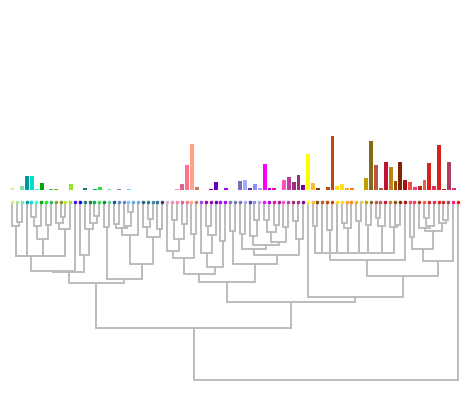

In [20]:
%matplotlib inline
xx = treeobj['x'].values
yy = treeobj['y'].values
yy[np.isnan(yy)]=0
isleaf = treeobj['leaf'].values==True 
col = treeobj['col'].values
col[~isleaf]='#000000'

sns.set_style("white")
fig=plt.figure(figsize=(7,7))

for p in parent:
    xp=xx[child==p]
    yp=yy[child==p]
    ch=child[parent==p]
    for c in ch:
        xc=xx[child==c]
        yc=yy[child==c]
        plt.plot([xc,xc],[-yc,-yp],color='#BBBBBB')
        plt.plot([xc,xp],[-yp,-yp],color='#BBBBBB')

totalcounts = 0
for i,s in enumerate(child):
    if col[i]!='#000000':
        #plt.text(xx[i], yy[i], s,horizontalalignment='center',verticalalignment='top',rotation=90,color=col[i],fontsize=10)
        totalcounts = totalcounts+np.sum(matfile['cluster']==s)

count_list = []        
for i,s in enumerate(child):
    if col[i]!='#000000':
        #plt.text(xx[i], yy[i], s,horizontalalignment='center',verticalalignment='top',rotation=90,color=col[i],fontsize=10)
        counts = np.sum(matfile['cluster']==s)
        count_list.append(counts)
        plt.plot(xx[i], yy[i], '.',c=col[i],ms=5)
        plt.bar(xx[i], height=2*counts/totalcounts, width=1, bottom=yy[i]+0.03, align='center', color=col[i])

plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([np.min(xx)-1,np.max(xx)+1])
ax.set_ylim([-0.5,0.5])
ax.axis('off')

fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig2A.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

**Histograms with leaf node cell type names**

In [ ]:
#For SfN plots:
xx = treeobj['x'].values
yy = treeobj['y'].values
yy[np.isnan(yy)]=0
isleaf = treeobj['leaf'].values==True 
col = treeobj['col'].values
col[~isleaf]='#000000'

sns.set_style("white")
fig=plt.figure(figsize=(12,9.5))

for p in parent:
    xp=xx[child==p]
    yp=yy[child==p]
    ch=child[parent==p]
    for c in ch:
        xc=xx[child==c]
        yc=yy[child==c]
        plt.plot([xc,xc],[-yc-0.5,-yp-0.5],color='#BBBBBB')
        plt.plot([xc,xp],[-yp-0.5,-yp-0.5],color='#BBBBBB')

totalcounts = 0
for i,s in enumerate(child):
    if col[i]!='#000000':
        plt.text(xx[i], yy[i]-0.48, s,horizontalalignment='center',verticalalignment='bottom',rotation=90,color=col[i],fontsize=10)
        totalcounts = totalcounts+np.sum(matfile['cluster']==s)

count_list = []        
for i,s in enumerate(child):
    if col[i]!='#000000':
        #plt.text(xx[i], yy[i], s,horizontalalignment='center',verticalalignment='top',rotation=90,color=col[i],fontsize=10)
        counts = np.sum(matfile['cluster']==s)
        count_list.append(counts)
        plt.plot(xx[i], yy[i]-0.5, '.',c=col[i],ms=5)
        plt.bar(xx[i], height=10*counts/totalcounts, width=1, bottom=yy[i]+0.03, align='center', color=col[i])

plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
ax=plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([np.min(xx)-1,np.max(xx)+1])
ax.set_ylim([-1.5,.5])
ax.axis('off')

fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/FigS2.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

In [ ]:
leaf = np.logical_and(matfile['cluster_color']!='#808080',matfile['T_ispaired']==1)
leaf_names = matfile['cluster'][leaf]
[val,counts_paired_leaf] = np.unique(leaf_names, return_counts=True)
[val,counts_all_T] = np.unique(matfile['cluster'][matfile['cluster_color']!='#808080'], return_counts=True)

print('n(types) in paired data: '+str(np.sum(counts_paired_leaf>0)))
print('n(types) in paired data with > 6 samples: '+str(np.sum(counts_paired_leaf>6)))
print('n(types) in all transcriptomic data: '+str(np.sum(counts_all_T>0)))